In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy
import scipy.stats
#import matplotlib.colors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from epi.models import Parameter, Model
from epi.normalizing_flows import NormalizingFlow
from epi.util import pairplot, AugLagHPs, plot_T_x
import tensorflow as tf
from epi.SSSN import SSSN_sim, SSSN_sim_traj, plot_contrast_response, \
                     get_Fano, load_SSSN_variable
from scipy.io import loadmat
import os

In /Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/sbittn

In [2]:
neuron_inds = {'E':0, 'P':1, 'S':2, 'V':3}
figdir = "../../written/V1_model/figs/"

black = np.array([0, 0, 0])
blue = '#4769A0'
red = '#AF3A31'
green = '#287C5A'
colors = [black, blue, red, green]

data = loadmat(os.path.join("data", "AgosBiorxiv2.mat"))['data']

inds = [62]
dt = 0.0005
T = 150
T_plot = 250

### 1. Show fit compared to data.

(6,) (6, 1, 8)
../../written/V1_model/figs/Fig3/fit.png


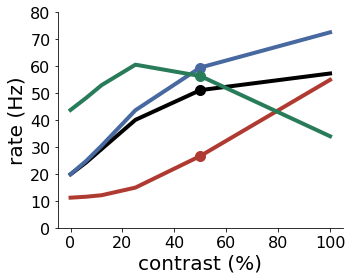

In [3]:
for ind in inds:
    W_mat = load_SSSN_variable('W', ind=ind)
    hb = load_SSSN_variable('hb', ind=ind)
    hc = load_SSSN_variable('hc', ind=ind)

    sssn_sim = SSSN_sim(0., W_mat, dt=dt, T=T_plot)

    fig, ax = plt.subplots(1,1, figsize=(5,4))
    c_points = np.array([0.5])
    hs = hb[None,:] + c_points[:,None]*hc[None,:]
    x_ss_points = sssn_sim(hs).numpy()
    plot_contrast_response(c_points, 100*x_ss_points[:,0,:], colors=colors, linestyle='o', ax=ax)
    
    c = np.array([0., 0.06, 0.12, 0.25, 0.5, 1.])
    hs = hb[None,:] + c[:,None]*hc[None,:]
    x_ss = sssn_sim(hs).numpy()
    print(c.shape, x_ss.shape)
    plot_contrast_response(c, 100*x_ss[:,0,:], colors=colors, ax=ax, fontsize=20)
    
    if ind == 62:
        fname = os.path.join(figdir, "Fig3", "fit.png")
    print(fname)
    plt.tight_layout()
    plt.savefig(fname)

### 2. Calculate equivalence class for greater rates.  Check factor increase of k=100.

In [4]:
print(hb, hc)

tf.Tensor([0.41588497 0.4286093  0.4907676  0.4861505 ], shape=(4,), dtype=float32) tf.Tensor([0.35919505 0.40300423 0.         0.        ], shape=(4,), dtype=float32)


W fit
tf.Tensor(
[[ 2.1781893e+00 -1.1870320e+00 -5.9459770e-01 -2.2886373e-01]
 [ 1.6559428e+00 -6.5134937e-01 -6.7955399e-01 -2.4190041e-01]
 [ 8.9537537e-01 -5.2245674e-03 -1.5110424e-04 -7.6099437e-01]
 [ 3.3443694e+00 -2.3140862e+00 -2.5393552e-01 -2.5296208e-04]], shape=(4, 4), dtype=float32)

h fit
tf.Tensor([0.59548247 0.63011146 0.4907676  0.4861505 ], shape=(4,), dtype=float32)

W adjusted
tf.Tensor(
[[ 2.1781895e-01 -1.1870320e-01 -5.9459776e-02 -2.2886375e-02]
 [ 1.6559428e-01 -6.5134943e-02 -6.7955405e-02 -2.4190044e-02]
 [ 8.9537539e-02 -5.2245677e-04 -1.5110425e-05 -7.6099440e-02]
 [ 3.3443698e-01 -2.3140863e-01 -2.5393555e-02 -2.5296211e-05]], shape=(4, 4), dtype=float32)

h adjusted
tf.Tensor(
[[5.9548244]
 [6.3011146]
 [4.9076757]
 [4.861505 ]], shape=(4, 1), dtype=float32)


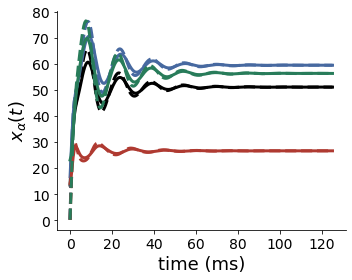

In [5]:
def get_equivalence(k, W_mat, h, n=2):
    D = W_mat.shape[0]
    A = k*tf.eye(D)
    W_mat_new = tf.matmul(tf.matmul(A, W_mat), tf.linalg.inv(A)**n)
    h_new = tf.matmul(A, h)
    return A, W_mat_new, h_new

k = 100

W_mat = load_SSSN_variable('W', ind=ind)
hb = load_SSSN_variable('hb', ind=ind)
hc = load_SSSN_variable('hc', ind=ind)

contrast = 0.5
h = hb+contrast*hc

A_k, W_mat_k, h_k = get_equivalence(10., W_mat, h[:,None])
print('W fit')
print(W_mat)
print('\nh fit')
print(h)

print('\nW adjusted')
print(W_mat_k)
print('\nh adjusted')
print(h_k)

alphas = ['E', 'P', 'S', 'V']
fontsize=18
t = dt*np.arange(T_plot+1)

_h = h[None,:]
_h_k = h_k[None,:,0]

fig, ax = plt.subplots(1,1, figsize=(5,4))

np.random.seed(1)
sssn_sim_traj = SSSN_sim_traj(np.zeros((1,4)), W_mat, dt=dt, T=T_plot)
sssn_sim_traj_k = SSSN_sim_traj(np.zeros((1,4)), W_mat_k, dt=dt, T=T_plot)

r_t1 = np.dot(A_k**2, sssn_sim_traj(_h)[0,0,:4])
r_t2 = sssn_sim_traj_k(_h_k)[0,0,:4]
for neuron in alphas:
    j = neuron_inds[neuron]
    label_det = ''
    ax.plot(1e3*t, r_t1[j], '-', c=colors[j], 
             lw=3, label=label_det)
    ax.plot(1e3*t, r_t2[j], '--', c=colors[j], 
             lw=3, label='')
plt.setp(ax.get_xticklabels(), fontsize=(fontsize-4))
plt.setp(ax.get_yticklabels(), fontsize=(fontsize-4))
ax.set_xlabel('time (ms)', fontsize=fontsize)
ax.set_ylabel(r'$x_\alpha(t)$', fontsize=fontsize)
plt.tight_layout()
plt.show()

### 3. Show the paradoxical effect.

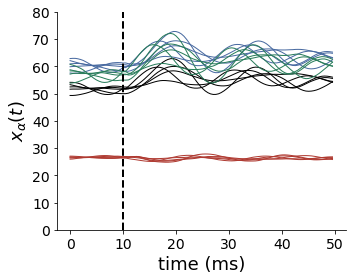

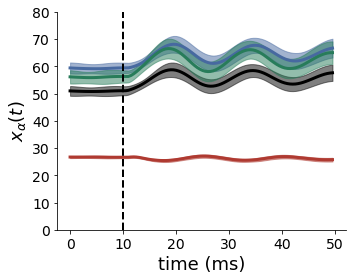

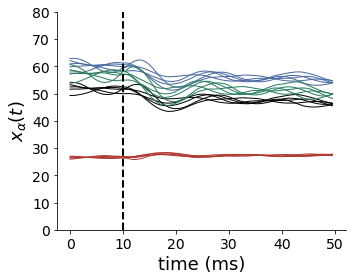

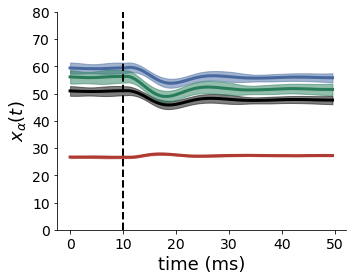

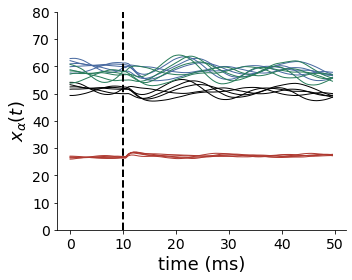

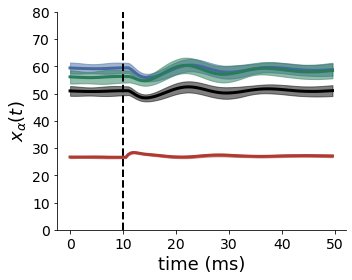

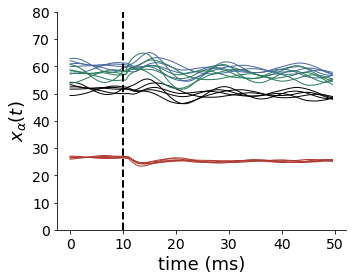

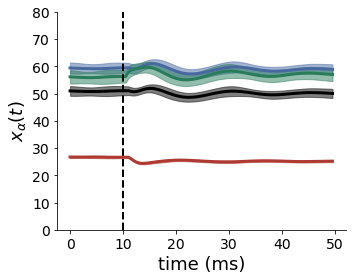

In [6]:
contrast = 0.5
alphas = ['E', 'P', 'S', 'V']
fontsize=18
ind = 62
dh_vals = [0.002, 0.002, 0.02, 0.02]
N_plot = 5
N = 50
sigma_eps = 0.5e-3*np.ones((1,4))
for dh_type, dh_val in zip(alphas, dh_vals):
    np.random.seed(0)
    tf.random.set_seed(0)
    W_mat = load_SSSN_variable('W', ind=ind)
    hb = load_SSSN_variable('hb', ind=ind)
    hc = load_SSSN_variable('hc', ind=ind)
    sssn_sim_traj = SSSN_sim_traj(sigma_eps, W_mat, N=N, dt=dt, T=T_plot)
    h = (hb + contrast*hc)[None,:]
    
    r_t1 = sssn_sim_traj(h)[0,:,:4]
    
    x_init = r_t1[:,:,-1][None,:,:]
    sssn_PE_sim_traj = SSSN_sim_traj(sigma_eps, W_mat, N=N, dt=dt, T=T_plot, x_init=x_init)
    
    dh = np.zeros((1,4))
    dh[0,neuron_inds[dh_type]] = dh_val
    r_t2 = sssn_PE_sim_traj(h+dh)[0,:,:4]
   
    start_ind = 230
    end_ind = 330
    r_t = tf.concat((r_t1, r_t2), axis=2).numpy()[:,:,start_ind:end_ind]
    t_stim = (T_plot-start_ind)*dt
    t = dt*np.arange(r_t.shape[2])
    
    fig, ax = plt.subplots(1,1, figsize=(5,4))
    for neuron in alphas:
        j = neuron_inds[neuron]
        label_det = ''
        ax.plot(1e3*t, 100*r_t[:N_plot,j,:].T, '-', c=colors[j], 
                 lw=1, label=label_det)
    plt.setp(ax.get_xticklabels(), fontsize=(fontsize-4))
    plt.setp(ax.get_yticklabels(), fontsize=(fontsize-4))
    ax.plot([t_stim*1e3,t_stim*1e3], [0,80], 'k--')
    ax.set_xlabel('time (ms)', fontsize=fontsize)
    ax.set_ylabel(r'$x_\alpha(t)$', fontsize=fontsize)
    ax.set_ylim([0., 80.])
    plt.tight_layout()
    #plt.savefig(os.path.join(figdir, "FigV1_1", "sims_dh=%s.png" % dh_type))
    plt.show()
    
    fig, ax = plt.subplots(1,1, figsize=(5,4))
    for neuron in alphas:
        j = neuron_inds[neuron]
        label_det = ''
        _mean = 100*np.mean(r_t[:,j,:], axis=0)
        _std = 100*np.std(r_t[:,j,:], axis=0)
        ax.fill_between(1e3*t, _mean-_std, _mean+_std, color=colors[j], alpha=0.5)
        ax.plot(1e3*t, _mean, '-', lw=3, c=colors[j])
    plt.setp(ax.get_xticklabels(), fontsize=(fontsize-4))
    plt.setp(ax.get_yticklabels(), fontsize=(fontsize-4))
    ax.plot([t_stim*1e3,t_stim*1e3], [0,80], 'k--')
    ax.set_xlabel('time (ms)', fontsize=fontsize)
    ax.set_ylabel(r'$x_\alpha(t)$', fontsize=fontsize)
    ax.set_ylim([0., 80.])
    plt.tight_layout()
    #plt.savefig(os.path.join(figdir, "FigV1_1", "stats_dh=%s.png" % dh_type))
    plt.show()
    

### 3.1 Load epi distribution.

In [7]:
from epi.SSSN import get_Fano_sigma
ff_mean = 1.
ff_std = 0.125
alpha = 'E'
lim = 0.005

D = 4
lb = np.zeros((D,))
ub = lim*np.ones((D,))
sigma_eps = Parameter("sigma_eps", D, lb=lb, ub=ub)

name = "SSSN_ff_sigma_%s_%.2E_%.2E_ind=%d" % (alpha, ff_mean, ff_std, ind)
parameters = [sigma_eps]
model = Model(name, parameters)

dt = 0.0005
T = 150
N = 50

fano = get_Fano_sigma(alpha, W_mat, h, N=N, dt=dt, T=T, T_ss=T-50, mu=ff_mean)
model.set_eps(fano)

epi_df = model.get_epi_df()

path = "data/epi/SSSN_ff_sigma_E_1.00E+00_1.25E-01_ind=62/085ee8ec322138b4bc921e5396bacae3/D4_C3_affine_L2_U50_rs2/1fbbf40c743ff0ea891288a0df92b6a4/N100_lr1.00E-03_c0=1.00E+02_gamma2.50E-01_beta4.00E+00"
best_k = 6

df_row = epi_df[epi_df['path']==path].iloc[0]
dist = model.get_epi_dist(df_row, k=best_k)

ckpt_dir data/epi/SSSN_ff_sigma_E_1.00E+00_1.25E-01_ind=62/085ee8ec322138b4bc921e5396bacae3/D4_C3_affine_L2_U50_rs2/1fbbf40c743ff0ea891288a0df92b6a4/N100_lr1.00E-03_c0=1.00E+02_gamma2.50E-01_beta4.00E+00
ckpt_state model_checkpoint_path: "data/epi/SSSN_ff_sigma_E_1.00E+00_1.25E-01_ind=62/085ee8ec322138b4bc921e5396bacae3/D4_C3_affine_L2_U50_rs2/1fbbf40c743ff0ea891288a0df92b6a4/N100_lr1.00E-03_c0=1.00E+02_gamma2.50E-01_beta4.00E+00/ckpt-6"
all_model_checkpoint_paths: "data/epi/SSSN_ff_sigma_E_1.00E+00_1.25E-01_ind=62/085ee8ec322138b4bc921e5396bacae3/D4_C3_affine_L2_U50_rs2/1fbbf40c743ff0ea891288a0df92b6a4/N100_lr1.00E-03_c0=1.00E+02_gamma2.50E-01_beta4.00E+00/ckpt-0"
all_model_checkpoint_paths: "data/epi/SSSN_ff_sigma_E_1.00E+00_1.25E-01_ind=62/085ee8ec322138b4bc921e5396bacae3/D4_C3_affine_L2_U50_rs2/1fbbf40c743ff0ea891288a0df92b6a4/N100_lr1.00E-03_c0=1.00E+02_gamma2.50E-01_beta4.00E+00/ckpt-1"
all_model_checkpoint_paths: "data/epi/SSSN_ff_sigma_E_1.00E+00_1.25E-01_ind=62/085ee8ec322138b

### 3.2 Plot epi distribution.

Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.


/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:2273: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


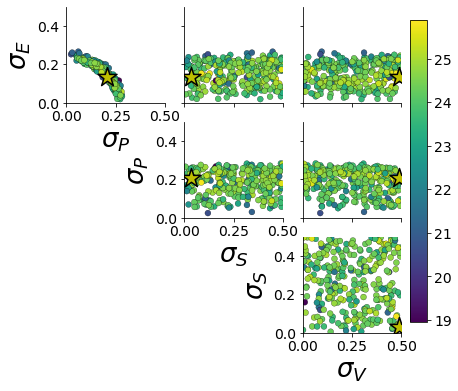

In [8]:
M = 300
np.random.seed(1)
tf.random.set_seed(1)
z, log_q_z = dist.nf(M)
z, log_q_z = z.numpy(), log_q_z.numpy()

z_mode = z[np.argmax(log_q_z), :][None,:]

alphas = ['E', 'P', 'S', 'V']
z_labels = [r'$\sigma_%s$' % alpha for alpha in alphas]
fig = pairplot(1e2*z, np.arange(4), z_labels, starred=1e2*z_mode, c_starred=['y'], 
               fontsize=26, figsize=(6,6), ticksize=14, s=35, c_label='', 
               lb=lb, ub=1e2*ub, c=log_q_z)
#plt.savefig(os.path.join(figdir, "Fig3", "PanelD.png"))
plt.show()

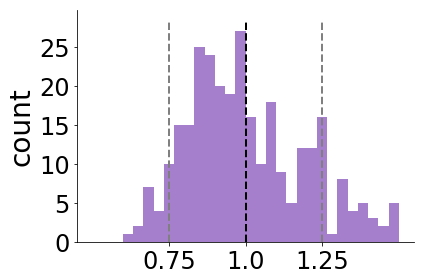

In [11]:
T_x = model.eps(z).numpy()
plot_T_x(None, T_x[:,0], bins=30, xmin=.5, xmax=1.5,
             x_mean=ff_mean, x_std=ff_std, figsize=None,
             xlabel='', ylim=None, fontsize=28)
plt.tight_layout()
#plt.savefig(os.path.join(figdir, "Fig3", "PanelD_T_x.png"), transparent=True)
plt.show()

### 3.3 Analyze the ridge.

In [12]:
def get_conditional_mode(dist, alpha, val, step=1e-6, num_steps=100):
    ind = neuron_inds[alpha]
    z0_np = ((dist.nf.lb + dist.nf.ub) / 2.)
    z0_np[ind] = val
    z = tf.Variable(initial_value=z0_np[None,:], dtype=tf.float32, trainable=True)
    
    log_q_z = dist.log_prob(z.numpy())
    
    zs = [z]
    log_q_zs = [log_q_z]
    
    for k in range(num_steps):
        grad_z = dist._gradient(z).numpy()
        z_np = z.numpy()
        z_next = z_np + step * grad_z
        z_next[0,ind] = val
        for j in range(4):
            if z_next[0,j] < lb[j]:
                z_next[0,j] = lb[j]
            if z_next[0,j] > ub[j]:
                z_next[0,j] = ub[j]
        z = tf.Variable(initial_value=z_next, 
                        dtype=tf.float32, trainable=True)
        
        log_q_z = dist.log_prob(z_next)
        zs.append(z_next[0])
        log_q_zs.append(log_q_z)
        
    return zs, log_q_zs
       
sigma_P_vals = np.arange(0.0005, 0.002751, 0.00025)
ridge_zs = []
ridge_log_q_zs = []
for sigma_P_val in sigma_P_vals:
    zs, log_q_zs = get_conditional_mode(dist, 'P', sigma_P_val, step=5.0e-9, num_steps=50)
    print(sigma_P_val, zs[-1])
    ridge_zs.append(zs[-1])
    ridge_log_q_zs.append(log_q_zs[-1])
    
ridge_zs = np.array(ridge_zs)
ridge_log_q_zs = np.array(ridge_log_q_zs)

0.0005 [0.00238083 0.0005     0.0025071  0.00254594]
0.00075 [0.00231163 0.00075    0.00249333 0.00252686]
0.001 [0.00220605 0.001      0.00244988 0.0025375 ]
0.00125 [0.00208498 0.00125    0.0024301  0.00253904]
0.0015 [0.00192494 0.0015     0.00244522 0.0025092 ]
0.00175 [0.00176905 0.00175    0.00244735 0.00248842]
0.002 [0.00153936 0.002      0.00249101 0.00247626]
0.0022500000000000003 [0.00121418 0.00225    0.00246321 0.00248662]
0.0025 [0.00088532 0.0025     0.002584   0.00251211]
0.0027500000000000003 [0.0003873  0.00275    0.00265355 0.00247972]


In [ ]:
hess_z = dist.hessian(ridge_zs)
vs = []
for i, sigma_P_val in enumerate(sigma_P_vals):
    hess_z_i = hess_z[i]
    d, v = np.linalg.eig(hess_z_i)
    min_ind = np.argmin(d)
    _v = v[:,min_ind]
    if (_v[0] < 0.):
        _v = -_v
    vs.append(_v)
    
vs = np.array(vs)

NameError: name 'ridge_zs' is not defined

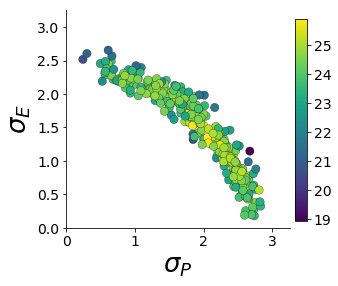

In [132]:
fig, ax = pairplot(1e2*z, np.arange(2), z_labels, 
               fontsize=26, figsize=(4,4), ticksize=14, s=70,
               lb=lb, ub=.325*np.ones((4,)), c=log_q_z, c_label='')
ridge_color = np.array([0.,0.,0.,.5])
ax.scatter(1e3*ridge_zs[:,1], 1e3*ridge_zs[:,0], c=ridge_color, s=70)
ax.plot(1e3*ridge_zs[:,1], 1e3*ridge_zs[:,0], '-', c=ridge_color)
fac = 0.0005
for i, sigma_P_val in enumerate(sigma_P_vals):
    vx = 1e2*np.array([ridge_zs[i,1], ridge_zs[i,1]+fac*vs[i,1]])
    vy = 1e2*np.array([ridge_zs[i,0], ridge_zs[i,0]+fac*vs[i,0]])
    ax.annotate("", xy=[vx[1], vy[1]], xytext=[vx[0], vy[0]], 
                 arrowprops=dict(headwidth=8, headlength=8, lw=.25, color=ridge_color))
plt.tight_layout()
#plt.savefig(os.path.join(figdir, "Fig3", "PanelE_zoom.png"))

In [77]:
def sensitivity(model, z, v, fac_lim=0.005):
    facs = np.linspace(-fac_lim, fac_lim, 51)
    z_perturb = z + facs[:,None]*v
    T_x_perturb = model.eps(z_perturb)
    d = np.abs(T_x_perturb[:,0] - ff_mean)
    a, b, r, p, _ = scipy.stats.linregress(facs, d)
    return b, r

def rvs(D, N):
    v = np.random.normal(0., 1., (N,D))
    v = v / np.linalg.norm(v, axis=1)[:,None]
    return v

sigma_P_vals = np.arange(0.0005, 0.002751, 0.00025)

fac_lim = 0.0025
n_rand = 200
v_rands = rvs(4, n_rand)
bs = []
rs = []
b_rands = []
r_rands = []
for i, sigma_P_val in enumerate(sigma_P_vals):
    print(i, sigma_P_val)
    z_i = ridge_zs[i][None]
    v_i = vs[i][None]
    
    _b, _r = sensitivity(model, z_i, v_i, fac_lim=fac_lim)
    bs.append(_b)
    rs.append(_r)
    _sens_rand = [sensitivity(model, z_i, v_rands[i][None,:], fac_lim=fac_lim)
               for j in range(n_rand)]
    _b_rands = [_sens_rand[j][0] for j in range(n_rand)]
    _r_rands = [_sens_rand[j][1] for j in range(n_rand)]
    b_rands.append(np.array(_b_rands))
    r_rands.append(np.array(_r_rands))


0 0.0005
1 0.00075
2 0.001
3 0.00125
4 0.0015
5 0.00175
6 0.002
7 0.0022500000000000003
8 0.0025
9 0.0027500000000000003


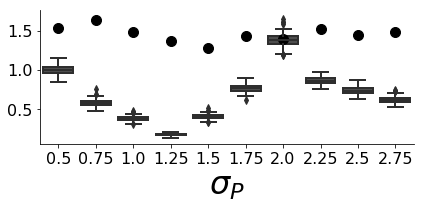

In [85]:
import seaborn as sns
fontsize = 32
ticksize = fontsize - 16
plt.figure(figsize=(6,3))
ax = sns.boxplot(x=np.round(1e3*sigma_P_vals, 2), y=b_rands, color=.3*np.ones(3))
ax.scatter(np.arange(len(bs)), bs, c='k')
ax.set_xlabel(r'$\sigma_P$', fontsize=fontsize)
plt.setp(ax.get_xticklabels(), fontsize=ticksize)
plt.setp(ax.get_yticklabels(), fontsize=ticksize)
#ax.set_ylim([-.1, .9])
plt.tight_layout()
#plt.savefig(os.path.join(figdir, "Fig3", "PanelE_sens.png"), transparent=True)
plt.show()

In [65]:
"""Fano_extra = get_Fano_sigma(alpha, W_mat, h, N=N, dt=dt, T=300, T_ss=150, mu=ff_mean)
model.set_eps(Fano_extra)

T_x = model.eps(z).numpy()
plot_T_x(None, T_x[:,0], bins=30, xmin=.5, xmax=1.5,
             x_mean=ff_mean, x_std=ff_std, figsize=None,
             xlabel=r'$F(x; z)$', ylim=None, fontsize=28)"""

"Fano_extra = get_Fano_sigma(alpha, W_mat, h, N=N, dt=dt, T=300, T_ss=150, mu=ff_mean)\nmodel.set_eps(Fano_extra)\n\nT_x = model.eps(z).numpy()\nplot_T_x(None, T_x[:,0], bins=30, xmin=.5, xmax=1.5,\n             x_mean=ff_mean, x_std=ff_std, figsize=None,\n             xlabel=r'$F(x; z)$', ylim=None, fontsize=28)"

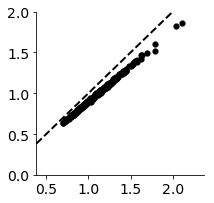

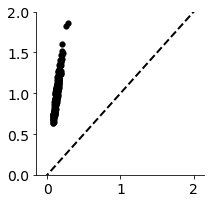

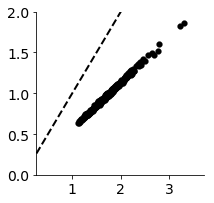

In [74]:
Fano_all = get_Fano_sigma('all', W_mat, h, N=N, dt=dt, T=T, T_ss=T-50, mu=ff_mean)
fano_all = Fano_all(z).numpy()

fano_labels = [r'$F_%s$' % alpha for alpha in alphas]
inhib_types = ['P', 'S', 'V']
for alpha in inhib_types:
    alpha_ind = neuron_inds[alpha]
    fano_E_alpha = np.stack((fano_all[:,0], fano_all[:,alpha_ind]), axis=1)
    fig, ax = pairplot(fano_E_alpha, np.arange(2), ['', ''],
                   fontsize=24, figsize=(3,3), ticksize=14, s=35,
                   lb=np.zeros(2,), ub=3.*np.ones((2,)), unity_line=True)
    ax.set_ylim([0., 2.])
    #plt.savefig(os.path.join(figdir, "Fig3", "PanelF_E%s.png" % alpha))
    plt.show()

In [90]:
#sigma_eps = np.array([[2.7747380e-02, 2.9908607e-02,  1.0897118e-03, 1.3312697e-05]])
sigma_eps = np.array([[0.00175, 0.00175, 0.002, 0.002]])

_c = np.linspace(0, 1, 25)

_N = 5
hs = hb[None,:] + _c[:,None]*hc[None,:]
F_means = []
F_stds = []
for m in range(200):
    sigma_eps = z[m,:][None,:]
    Fano = get_Fano('all', sigma_eps, W_mat, dt=dt, N=N, T=T)
    Fs = []
    for k in range(_N):
        print('m=%d: %2d/%2d \r' % (m+1, k+1, _N), end="")
        Fs.append(Fano(hs).numpy())
    Fs = np.array(Fs)
    F_means.append(np.mean(Fs, axis=0))
    F_stds.append(np.std(Fs, axis=0))

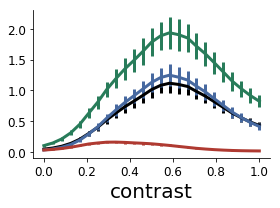

In [91]:
F_means = np.array(F_means)
F_stds = np.array(F_stds)
fig, ax = plt.subplots(1, 1, figsize=(4,3))
fontsize= 20
for ii in range(4):
    ax.errorbar(_c, np.mean(F_means[:,:,ii], axis=0), 
                np.std(F_means[:,:,ii], axis=0), c=colors[ii], lw=3)
ax.set_xlabel('contrast', fontsize=fontsize)
plt.tight_layout()
#plt.savefig(os.path.join(figdir, "Fig3", "PanelG.png"))
plt.show()

F_mean (10, 8)
F_std (10, 8)


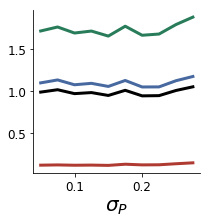

In [14]:
Ns = [50]
Ts = [150]
F_means = {}
F_stds = {}
_N = 50
for N in Ns:
    for T in Ts:
        Fano = get_Fano_sigma('all', W_mat, h, dt=dt, N=N, T=T)
        sigma_eps = ridge_zs
        Fs = []
        for k in range(_N):
            print('%2d/%2d \r' % (k+1, _N), end="")
            Fs.append(Fano(sigma_eps).numpy())
        Fs = np.array(Fs)
        F_means.update({(N,T): np.mean(Fs, axis=0)})
        F_stds.update({(N,T): np.std(Fs, axis=0)})

fig, axs = plt.subplots(len(Ns), len(Ts), figsize=(3,3))
fontsize= 20
for i, N in enumerate(Ns):
    for j, T in enumerate(Ts):
        if len(Ns) == 1:
            if len(Ts) == 1:
                ax = axs
            else:
                ax = axs[j]
        elif len(Ts) == 1:
            ax = axs[i]
        else:
            ax = axs[i,j]
        F_mean = F_means[(N,T)]
        F_std = F_stds[(N,T)]
        print('F_mean', F_mean.shape)
        print('F_std', F_std.shape)
        for ii in range(4):
            #plt.errorbar(_c, h_var[:,i], h_var[:,i+4], c=colors[i])
            #ax.errorbar(np.arange(5), F_mean[:,ii], F_std[:,ii], c=colors[ii])
            ax.plot(1e2*sigma_P_vals, F_mean[:,ii], c=colors[ii], lw=3)
            #plt.plot(_c, h_var[:,i], c=colors[i])
        if (i==(len(Ns)-1)):
            ax.set_xlabel(r'$\sigma_P$', fontsize=fontsize)
        #if (j==0):
            #ax.set_ylabel(r'$F(x; z)$', fontsize=fontsize)
        #ax.set_ylim([0, 0.05])
plt.show()


0.05345521893470395
198.12273 202.37111 0.33196604


(0, 0.003)

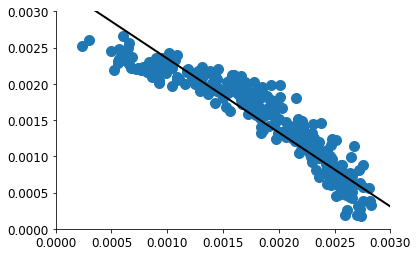

In [110]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression().fit(z[:,:2], T_x[:,0])
print(linreg.score(z[:,:2], T_x[:,0]))
a, b = linreg.coef_
c = linreg.intercept_
print(a,b,c)
x2 = np.linspace(0., 0.003, 7)
x1 = (1./a)*(-b*x2 - c + 1)
plt.figure()
plt.scatter(z[:,1], z[:,0])
plt.plot(x2, x1, 'k')
plt.xlim([0,.003])
plt.ylim([0,.003])

In [125]:
fano = get_Fano_sigma(alpha, W_mat, h, N=N, dt=dt, T=1000, T_ss=500, mu=ff_mean)
model.set_eps(fano)
T_x2 = model.eps(z)

0.2013501684955349
183393.33 152147.11 -0.06324375


/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  


(0, 0.003)

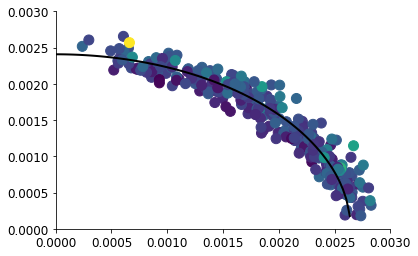

In [129]:
linreg = LinearRegression().fit(z[:,:2]**2, T_x[:,0])

print(linreg.score(z[:,:2]**2, T_x[:,0]))
a, b = linreg.coef_
c = linreg.intercept_
print(a,b,c)
x2 = np.linspace(0., 0.003, 100)
x1 = np.sqrt((1./a)*(-b*(x2**2) - c + 1.))
plt.figure()
plt.scatter(z[:,1], z[:,0], c=T_x[:,0])
plt.plot(x2, x1, 'k')
plt.xlim([0,.003])
plt.ylim([0,.003])

In [103]:
print(z)

[[0.0022198  0.00067846 0.00109395 0.00203018]
 [0.00212478 0.00130113 0.00465937 0.00251583]
 [0.0019276  0.00171507 0.00411682 0.00083306]
 ...
 [0.00200281 0.00116387 0.00074885 0.00303661]
 [0.00233102 0.0005979  0.00219432 0.00189279]
 [0.00194572 0.00145315 0.00206235 0.00164582]]
